## Import Data

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

In [251]:
df = pd.read_csv('/Users/rifqyadiyatma/Downloads/OnlineRetailData.csv')

df.head()

,order_id,product_code,product_name,quantity,order_date,price,customer_id
0,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.50,12346.0
1,C493411,21539,RETRO SPOTS BUTTER DISH,-1,2010-01-04 09:43:00,4.25,14590.0
2,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.50,12346.0
3,493413,21724,PANDA AND BUNNIES STICKER SHEET,1,2010-01-04 09:54:00,0.85,NaN
4,493413,84578,ELEPHANT TOY WITH BLUE T-SHIRT,1,2010-01-04 09:54:00,3.75,NaN


In [252]:
df.shape

(461773, 7)

In [253]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461773 entries, 0 to 461772
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      461773 non-null  object 
 1   product_code  461773 non-null  object 
 2   product_name  459055 non-null  object 
 3   quantity      461773 non-null  int64  
 4   order_date    461773 non-null  object 
 5   price         461773 non-null  float64
 6   customer_id   360853 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 24.7+ MB


## Data Cleaning

In [254]:
df.head()

,order_id,product_code,product_name,quantity,order_date,price,customer_id
0,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.50,12346.0
1,C493411,21539,RETRO SPOTS BUTTER DISH,-1,2010-01-04 09:43:00,4.25,14590.0
2,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.50,12346.0
3,493413,21724,PANDA AND BUNNIES STICKER SHEET,1,2010-01-04 09:54:00,0.85,NaN
4,493413,84578,ELEPHANT TOY WITH BLUE T-SHIRT,1,2010-01-04 09:54:00,3.75,NaN


In [255]:
clean_df = df.copy()

# Remove missing value in product name
clean_df= clean_df[~clean_df['product_name'].isna()]

# Change date type using datetime package
# clean_df['order_date'] = df['order_date'].astype('datetime64[ns]')
clean_df['order_date'] = pd.to_datetime(clean_df['order_date'], errors='coerce')

#Remove missing customer id
clean_df = clean_df[~clean_df['customer_id'].isna()]

# Make new column to create year and month period
clean_df['year_month'] = clean_df['order_date'].dt.to_period('M')

# Make all product name in lowercase
clean_df['product_name'] = clean_df['product_name'].str.lower()

# Remove all product name and product code that contain "TEST"
clean_df = clean_df[(~clean_df['product_code'].str.lower().str.contains('test')) | 
                    (~clean_df['product_name'].str.contains('test '))]

# Make a new column to see all order status, if the order_id begin with C then it's cancelled the other is delivered
clean_df['order_status'] = np.where(clean_df['order_id'].str[:1] == 'C', 'Cancelled', 'Delivered')

# Change quantity with minus value
clean_df['quantity'] = clean_df['quantity'].abs()

clean_df.head()

,order_id,product_code,product_name,quantity,order_date,price,customer_id,year_month,order_status
1,C493411,21539,retro spots butter dish,1,2010-01-04 09:43:00,4.25,14590.0,2010-01,Cancelled
6,493414,21844,retro spot mug,36,2010-01-04 10:28:00,2.55,14590.0,2010-01,Delivered
7,493414,21533,retro spot large milk jug,12,2010-01-04 10:28:00,4.25,14590.0,2010-01,Delivered
8,493414,37508,new england ceramic cake server,2,2010-01-04 10:28:00,2.55,14590.0,2010-01,Delivered
9,493414,35001G,hand open shape gold,2,2010-01-04 10:28:00,4.25,14590.0,2010-01,Delivered


In [256]:
# Remove price that have minus value
clean_df = clean_df[clean_df['price'] > 0]

# Create new columns to count total amount of the order
clean_df['amount'] = clean_df['quantity'] * clean_df['price']

#Remove time from order_date
clean_df['order_date'] = pd.to_datetime(clean_df['order_date'], errors='coerce').dt.date

# Change product name that have the same product code with other product name
most_freq_product_name = clean_df.groupby(['product_code','product_name'], as_index=False).agg(order_cnt=('order_id','nunique')).sort_values(['product_code','order_cnt'], ascending=[True,False])
most_freq_product_name['rank'] = most_freq_product_name.groupby('product_code')['order_cnt'].rank(method = 'first', ascending = False)
most_freq_product_name = most_freq_product_name[most_freq_product_name['rank'] == 1].drop(columns = ['order_cnt', 'rank'])
clean_df = clean_df.merge(most_freq_product_name.rename(columns = {'product_name' : 'most_freq_product_name'}), how = 'left', on = 'product_code')
clean_df['product_name'] = clean_df['most_freq_product_name']
clean_df = clean_df.drop(columns = 'most_freq_product_name')

# Change customer_id type to string
clean_df['customer_id'] = clean_df['customer_id'].astype(str)

# Remove Outliers
from scipy import stats
clean_df = clean_df[(np.abs(stats.zscore(clean_df[['quantity', 'amount']])) < 3).all(axis = 1)]

clean_df = clean_df.reset_index(drop = True)

clean_df

,order_id,product_code,product_name,quantity,order_date,price,customer_id,year_month,order_status,amount
0,C493411,21539,red retrospot butter dish,1,2010-01-04,4.25,14590.0,2010-01,Cancelled,4.25
1,493414,21844,red retrospot mug,36,2010-01-04,2.55,14590.0,2010-01,Delivered,91.80
2,493414,21533,retro spot large milk jug,12,2010-01-04,4.25,14590.0,2010-01,Delivered,51.00
3,493414,37508,new england ceramic cake server,2,2010-01-04,2.55,14590.0,2010-01,Delivered,5.10
4,493414,35001G,hand open shape gold,2,2010-01-04,4.25,14590.0,2010-01,Delivered,8.50
...,...,...,...,...,...,...,...,...,...,...
358464,539988,84380,set of 3 butterfly cookie cutters,1,2010-12-23,1.25,18116.0,2010-12,Delivered,1.25
358465,539988,84849D,hot baths soap holder,1,2010-12-23,1.69,18116.0,2010-12,Delivered,1.69
358466,539988,84849B,fairy soap soap holder,1,2010-12-23,1.69,18116.0,2010-12,Delivered,1.69
358467,539988,22854,cream sweetheart egg holder,2,2010-12-23,4.95,18116.0,2010-12,Delivered,9.90


## Exploratory Data Analysis 

In [257]:
df = clean_df.copy()

df.shape

(358469, 10)

In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358469 entries, 0 to 358468
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype    
---  ------        --------------   -----    
 0   order_id      358469 non-null  object   
 1   product_code  358469 non-null  object   
 2   product_name  358469 non-null  object   
 3   quantity      358469 non-null  int64    
 4   order_date    358469 non-null  object   
 5   price         358469 non-null  float64  
 6   customer_id   358469 non-null  object   
 7   year_month    358469 non-null  period[M]
 8   order_status  358469 non-null  object   
 9   amount        358469 non-null  float64  
dtypes: float64(2), int64(1), object(6), period[M](1)
memory usage: 27.3+ MB


In [259]:
df.describe()

,quantity,price,amount
count,358469.000000,358469.000000,358469.000000
mean,9.362754,3.087634,16.757486
std,16.288556,5.502037,25.312974
min,1.000000,0.001000,0.001000
25%,2.000000,1.250000,4.200000
50%,4.000000,1.950000,10.200000
75%,12.000000,3.750000,17.700000
max,216.000000,311.990000,313.200000


#### Order Id

In [260]:
df['order_id'].count()

358469

In [261]:
#see how many unique order id
df['order_id'].nunique()

19945

#### Quantity

In [262]:
# Quantity items sold
df['quantity'].sum()

3356257

In [263]:
# Average of Quantity Column
df['quantity'].mean()

9.362753822506269

In [264]:
# Median
df['quantity'].median()

4.0

In [265]:
#Mode
df['quantity'].mode()[0]

1

#### Product Name (tea)

In [266]:
# How many teas sold
df.loc[df['product_name'].str.contains('tea'), 'quantity'].sum()

125597

In [267]:
# Average tea sold
df.loc[df['product_name'].str.contains('tea'), 'quantity'].mean()

9.335984538764588

In [268]:
#Median
df.loc[df['product_name'].str.contains('tea'), 'quantity'].median()

4.0

In [269]:
#mode
df.loc[df['product_name'].str.contains('tea'), 'quantity'].mode()[0]

1

#### Product Name (coffee)

In [270]:
# How many coffees sold
df.loc[df['product_name'].str.contains('coffee'), 'quantity'].sum()

16500

In [271]:
# Average Coffees Sold
df.loc[df['product_name'].str.contains('coffee'), 'quantity'].mean()

8.620689655172415

In [272]:
# Median
df.loc[df['product_name'].str.contains('coffee'), 'quantity'].median()

6.0

In [273]:
# Mode
df.loc[df['product_name'].str.contains('coffee'), 'quantity'].mode()[0]

6

#### Quartile

##### Quantity

In [274]:
# Q1
df['quantity'].quantile(.25)

2.0

In [275]:
# Q3
df['quantity'].quantile(.75)

12.0

In [276]:
# Create a function to find interquartile range

def inter_q(x):
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    return q3 - q1

In [277]:
# Interquartile Range of Quantity

inter_q(df['quantity'])

10.0

##### Product Name (tea)

In [278]:
df.loc[df['product_name'].str.contains('tea'), 'quantity'].quantile(.25)

2.0

In [279]:
df.loc[df['product_name'].str.contains('tea'), 'quantity'].quantile(.75)

12.0

In [280]:
inter_q(df.loc[df['product_name'].str.contains('tea'), 'quantity'])

10.0

##### Product Name (coffee)

In [281]:
df.loc[df['product_name'].str.contains('coffee'), 'quantity'].quantile(.25)

3.0

In [282]:
df.loc[df['product_name'].str.contains('coffee'), 'quantity'].quantile(.75)

6.0

In [283]:
inter_q(df.loc[df['product_name'].str.contains('coffee'), 'quantity'])

3.0

### Descriptive Statistic With Grouping

##### Aggregate 1 Column

In [284]:
# Most sold items that contain tea
clean_df.loc[clean_df['product_name'].str.contains('tea')].groupby('product_name', 
            as_index=False)['quantity'].sum().sort_values('quantity', ascending=False)

,product_name,quantity
0,60 teatime fairy cake cases,20687
2,antique silver tea glass etched,13888
28,moroccan tea glass,6731
1,antique silver tea glass engraved,6248
33,potting shed tea mug,5224
...,...,...
11,cubic mug teatime cakes,6
16,english rose tea set in gift box,5
73,teatime funky flower backpack for 2,4
10,ceramic cake teapot with cherry,3


##### Aggregate 2 Columns

In [285]:
# Add total amount
df.loc[df['product_name'].str.contains('tea')].groupby('product_name', 
            as_index = False).agg(total_quantity = ('quantity', 'sum'), 
            total_amount = ('amount', 'sum')).sort_values('total_quantity', ascending = False)

,product_name,total_quantity,total_amount
0,60 teatime fairy cake cases,20687,10673.12
2,antique silver tea glass etched,13888,16178.96
28,moroccan tea glass,6731,5106.11
1,antique silver tea glass engraved,6248,7285.60
33,potting shed tea mug,5224,6350.64
...,...,...,...
11,cubic mug teatime cakes,6,15.30
16,english rose tea set in gift box,5,23.25
73,teatime funky flower backpack for 2,4,67.80
10,ceramic cake teapot with cherry,3,13.45


## Data Visualization

### Pivot Table

In [286]:
pd.pivot_table(df,
              index = 'order_date',
              columns = 'order_status',
              values = ['order_id', 'amount'],
              aggfunc = {'order_id' : pd.Series.nunique,
                        'amount' : 'sum'},
              fill_value = 0
              )

amount            order_id          
order_status Cancelled Delivered Cancelled Delivered
order_date                                          
2010-01-04      240.28   7851.70        10        23
2010-01-05       82.50  15466.14         3        30
2010-01-06        0.00   7554.85         0        12
2010-01-07      646.97  17088.39        31        37
2010-01-08       21.90  13403.00         1        35
...                ...       ...       ...       ...
2010-12-19       17.60   6169.22         2        16
2010-12-20      986.42  14584.93        24        44
2010-12-21      201.20   5119.03         9        19
2010-12-22       65.40   3675.40         5        11
2010-12-23      207.85   3967.57         8        14

[298 rows x 4 columns]

In [287]:
# Create new dataframe to count order status

df_order = df.groupby('order_status', as_index = False).agg(order_count = ('order_id', 'nunique'), 
                total_amount = ('amount', 'sum'))
df_order

,order_status,order_count,total_amount
0,Cancelled,3590,140737.010
1,Delivered,16355,5866302.163


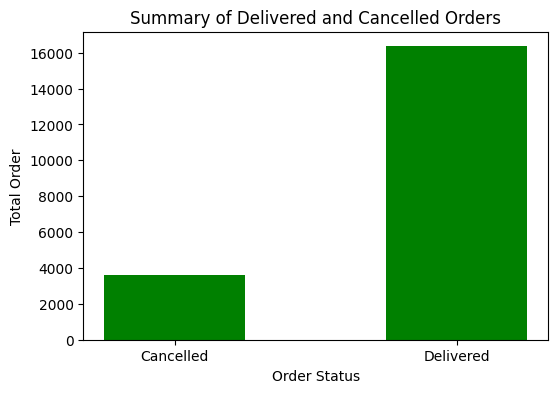

In [288]:
import matplotlib.pyplot as plt

# Total Order
fig = plt.figure(figsize = (6, 4))

plt.bar(df_order['order_status'], df_order['order_count'], color = 'green', width = 0.5)

plt.xlabel('Order Status')
plt.ylabel('Total Order')
plt.title('Summary of Delivered and Cancelled Orders')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

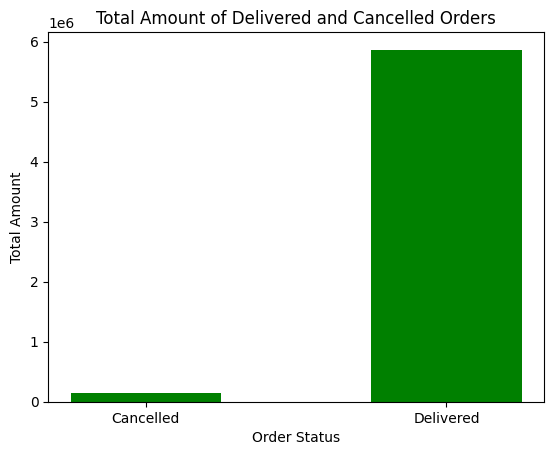

In [289]:
# Total Amount

plt.bar(df_order['order_status'], df_order['total_amount'], color = 'green', width = 0.5)
plt.xlabel('Order Status')
plt.ylabel('Total Amount')
plt.title('Total Amount of Delivered and Cancelled Orders')
plt.show

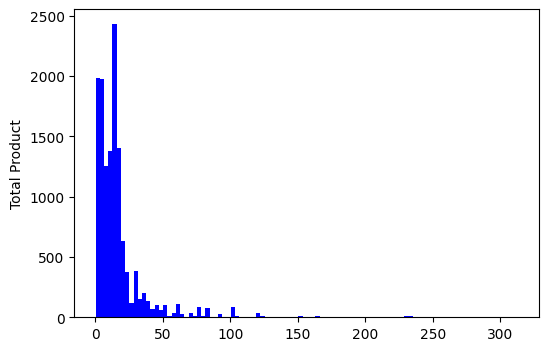

In [290]:
# Histogram of Product Name that contain tea

fig = plt.figure(figsize = (6, 4))
plt.hist(df.loc[df['product_name'].str.contains('tea'), 'amount'], 100, color = 'blue')
plt.ylabel('Total Product')
plt.show()

In [291]:
# Create new dataframe to count how many orders in a day

df_date = df.groupby('order_date', as_index = False).agg(total_orders = ('order_id', 'nunique'))
df_date

,order_date,total_orders
0,2010-01-04,33
1,2010-01-05,33
2,2010-01-06,12
3,2010-01-07,68
4,2010-01-08,36
...,...,...
293,2010-12-19,18
294,2010-12-20,68
295,2010-12-21,28
296,2010-12-22,16


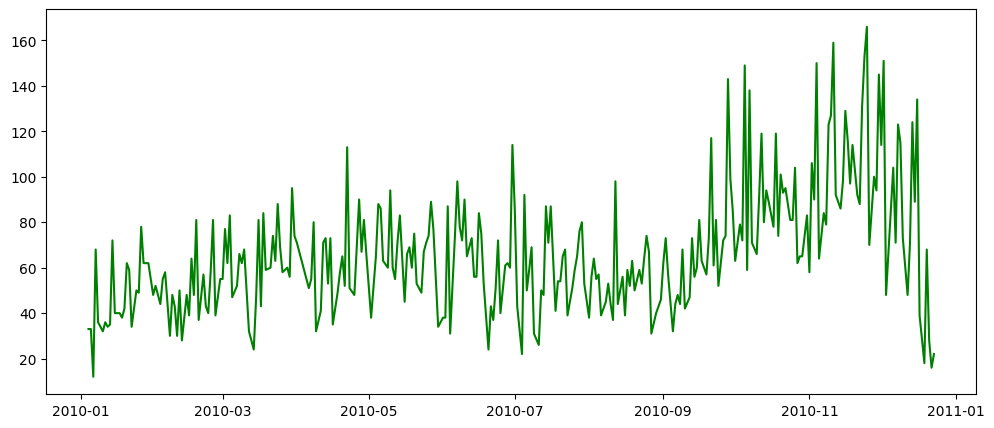

In [292]:
# Create line chart for visualization
fig = plt.figure(figsize = (12, 5))
plt.plot('order_date', 'total_orders', data = df_date, color = 'green', linestyle = '-')
plt.show()

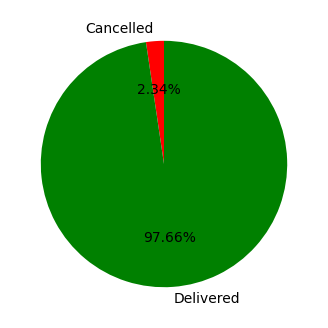

In [293]:
# Pie Chart
fig = plt.figure(figsize = (6, 4))
plt.pie(df_order['total_amount'], labels = df_order['order_status'], startangle = 90, 
       autopct = '%1.2f%%', colors = ['red', 'green'])
plt.show()

In [294]:
# Create new dataframe that consist only tea product

df_tea = df[df['product_name'].str.contains('tea')]
df_tea.head()

,order_id,product_code,product_name,quantity,order_date,price,customer_id,year_month,order_status,amount
5,493414,21527,red retrospot traditional teapot,12,2010-01-04,6.95,14590.0,2010-01,Delivered,83.40
7,C493415,21527,red retrospot traditional teapot,3,2010-01-04,7.95,14590.0,2010-01,Cancelled,23.85
17,493427,79000,moroccan tea glass,12,2010-01-04,0.85,13287.0,2010-01,Delivered,10.20
53,C493430,21527,red retrospot traditional teapot,1,2010-01-04,7.95,14680.0,2010-01,Cancelled,7.95
97,493432,22072,red retrospot tea cup and saucer,2,2010-01-04,3.75,14680.0,2010-01,Delivered,7.50


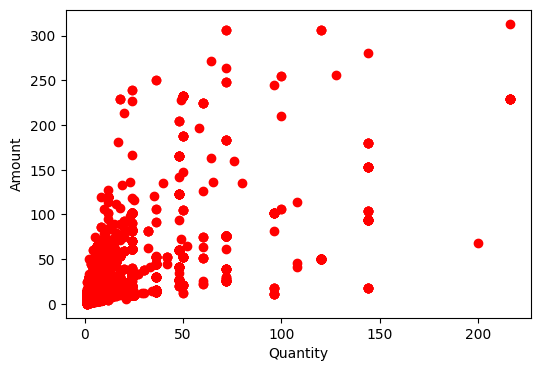

In [295]:
fig = plt.figure(figsize = (6, 4))
plt.scatter(df_tea['quantity'], df_tea['amount'], c = 'red', marker = 'o')
plt.xlabel('Quantity')
plt.ylabel('Amount')
plt.show()

Based on scatterplot above, we could see there is correlation between quantity and amount.

<Axes: ylabel='quantity'>

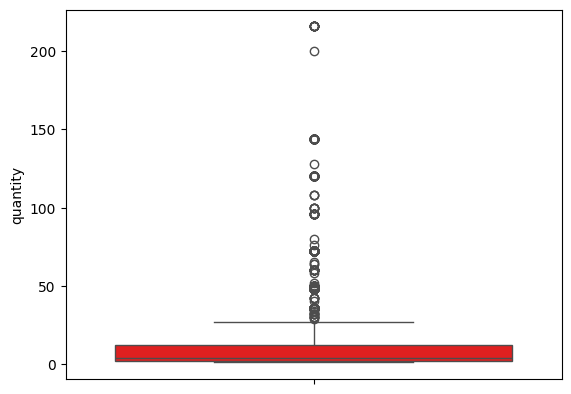

In [296]:
#Boxplot

import seaborn as sns

sns.boxplot(data = df_tea, y = 'quantity', color = 'red')

##### Heatmap to see correlation between columns

<Axes: >

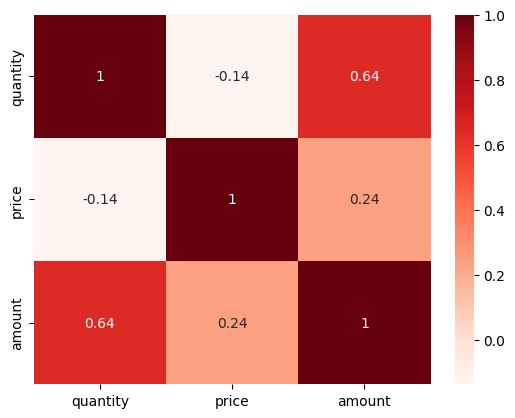

In [297]:
sns.heatmap(df.corr(numeric_only = True), cmap = 'Reds', annot = True)

## User Retention

In [298]:
df.head()

,order_id,product_code,product_name,quantity,order_date,price,customer_id,year_month,order_status,amount
0,C493411,21539,red retrospot butter dish,1,2010-01-04,4.25,14590.0,2010-01,Cancelled,4.25
1,493414,21844,red retrospot mug,36,2010-01-04,2.55,14590.0,2010-01,Delivered,91.80
2,493414,21533,retro spot large milk jug,12,2010-01-04,4.25,14590.0,2010-01,Delivered,51.00
3,493414,37508,new england ceramic cake server,2,2010-01-04,2.55,14590.0,2010-01,Delivered,5.10
4,493414,35001G,hand open shape gold,2,2010-01-04,4.25,14590.0,2010-01,Delivered,8.50


### Create summary of transaction by customer per month

In [299]:
df_monthly = df.groupby(['customer_id', 'year_month'], as_index = False).agg(order_count = ('order_id', 'nunique'))

df_monthly

,customer_id,year_month,order_count
0,12346.0,2010-01,1
1,12346.0,2010-03,1
2,12346.0,2010-06,2
3,12346.0,2010-10,1
4,12608.0,2010-10,1
...,...,...,...
12039,18286.0,2010-06,1
12040,18286.0,2010-08,1
12041,18287.0,2010-05,1
12042,18287.0,2010-09,2


### Cohort

Create a new column that contains the first month a customer made a transaction

In [300]:
df_monthly['cohort'] = df_monthly.groupby('customer_id')['year_month'].transform('min')
df_monthly

,customer_id,year_month,order_count,cohort
0,12346.0,2010-01,1,2010-01
1,12346.0,2010-03,1,2010-01
2,12346.0,2010-06,2,2010-01
3,12346.0,2010-10,1,2010-01
4,12608.0,2010-10,1,2010-10
...,...,...,...,...
12039,18286.0,2010-06,1,2010-06
12040,18286.0,2010-08,1,2010-06
12041,18287.0,2010-05,1,2010-05
12042,18287.0,2010-09,2,2010-05


Calculate range between the month of the last transaction and the month of the first transaction

In [301]:
from operator import attrgetter
df_monthly['range_period'] = (df_monthly['year_month'] - df_monthly['cohort']).apply(attrgetter('n')) + 1

df_monthly

,customer_id,year_month,order_count,cohort,range_period
0,12346.0,2010-01,1,2010-01,1
1,12346.0,2010-03,1,2010-01,3
2,12346.0,2010-06,2,2010-01,6
3,12346.0,2010-10,1,2010-01,10
4,12608.0,2010-10,1,2010-10,1
...,...,...,...,...,...
12039,18286.0,2010-06,1,2010-06,1
12040,18286.0,2010-08,1,2010-06,3
12041,18287.0,2010-05,1,2010-05,1
12042,18287.0,2010-09,2,2010-05,5


#### Pivot Table

In [303]:
df_pivot = pd.pivot_table(df_monthly, index = 'cohort', columns = 'range_period', 
                          values = 'customer_id', aggfunc = pd.Series.nunique)
df_pivot

range_period,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,
2010-01,713.0,280.0,334.0,313.0,305.0,304.0,293.0,268.0,285.0,319.0,335.0,249.0
2010-02,461.0,154.0,128.0,161.0,152.0,121.0,119.0,159.0,153.0,166.0,100.0,NaN
2010-03,528.0,146.0,158.0,145.0,140.0,123.0,149.0,186.0,193.0,96.0,NaN,NaN
2010-04,326.0,82.0,75.0,63.0,69.0,79.0,98.0,101.0,50.0,NaN,NaN,NaN
2010-05,274.0,55.0,50.0,52.0,52.0,72.0,67.0,43.0,NaN,NaN,NaN,NaN
2010-06,266.0,53.0,56.0,60.0,65.0,85.0,39.0,NaN,NaN,NaN,NaN,NaN
2010-07,179.0,38.0,37.0,52.0,53.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,160.0,35.0,50.0,48.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09,227.0,64.0,60.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Retention Count

In [306]:
# Create a list that contain the sum customer first transaction by month
cohort = df_pivot.iloc[:, 0]
cohort

cohort
2010-01    713.0
2010-02    461.0
2010-03    528.0
2010-04    326.0
2010-05    274.0
2010-06    266.0
2010-07    179.0
2010-08    160.0
2010-09    227.0
2010-10    362.0
2010-11    327.0
2010-12     66.0
Freq: M, Name: 1, dtype: float64

In [307]:
# Divide all the value in df_pivot by the cohort list

df_retention = df_pivot.divide(cohort, axis = 0)
df_retention

range_period,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,
2010-01,1.0,0.392707,0.468443,0.438990,0.427770,0.426367,0.410940,0.375877,0.399719,0.447405,0.469846,0.349229
2010-02,1.0,0.334056,0.277657,0.349241,0.329718,0.262473,0.258134,0.344902,0.331887,0.360087,0.216920,NaN
2010-03,1.0,0.276515,0.299242,0.274621,0.265152,0.232955,0.282197,0.352273,0.365530,0.181818,NaN,NaN
2010-04,1.0,0.251534,0.230061,0.193252,0.211656,0.242331,0.300613,0.309816,0.153374,NaN,NaN,NaN
2010-05,1.0,0.200730,0.182482,0.189781,0.189781,0.262774,0.244526,0.156934,NaN,NaN,NaN,NaN
2010-06,1.0,0.199248,0.210526,0.225564,0.244361,0.319549,0.146617,NaN,NaN,NaN,NaN,NaN
2010-07,1.0,0.212291,0.206704,0.290503,0.296089,0.167598,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,1.0,0.218750,0.312500,0.300000,0.168750,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09,1.0,0.281938,0.264317,0.136564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Visualize

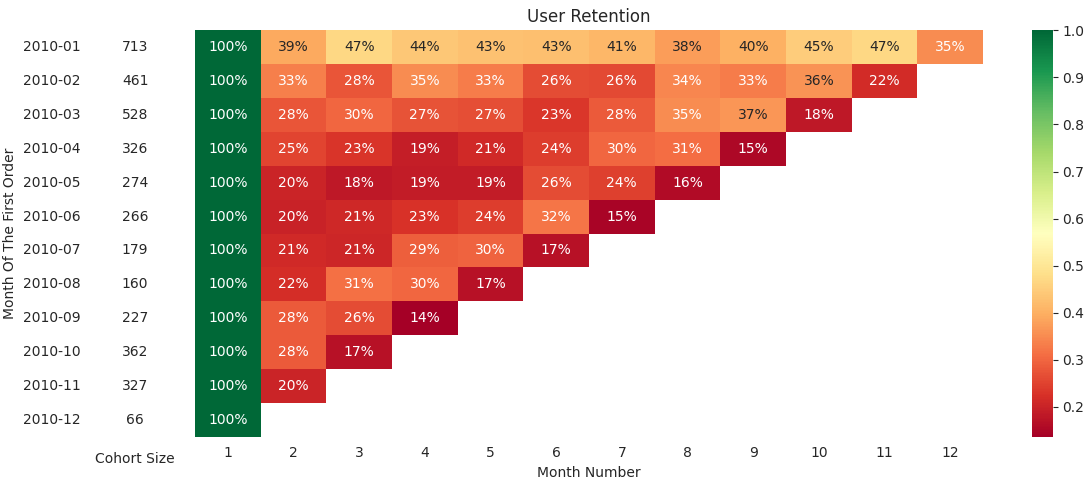

In [310]:
import matplotlib.colors as mcolors

with sns.axes_style('white'):

    fig, ax = plt.subplots(1, 2, figsize = (12, 5), sharey = True, gridspec_kw = {'width_ratios': [1, 11]})

    #User Retention
    sns.heatmap(df_retention, annot = True, fmt = '.0%', cmap = 'RdYlGn', ax = ax[1])
    ax[1].set_title('User Retention')
    ax[1].set(xlabel = 'Month Number', ylabel = '')

    #Cohort Size
    df_cohortSize = pd.DataFrame(cohort)
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(df_cohortSize, annot = True, cbar = False, fmt = 'g', cmap = white_cmap, ax = ax[0])
    ax[0].tick_params(bottom = False)
    ax[0].set(xlabel = 'Cohort Size', ylabel = 'Month Of The First Order', xticklabels = [])

    fig.tight_layout()

Berdasarkan heatmap diatas, pertama kali transaksi paling banyak terjadi di bulan Januari dengan jumlah customer sebesar 713 orang. Customer ini juga paling banyak berbelanja kembali dibulan ke-2 dengan nilai retention rate yaitu 39%. Customer yang pertama kali berbelanja dibulan Januari ini memiliki retention rate (kembali berbelanja dibulan-bulan berikutnya) tertinggi dibanding customer dibulan berikutnya dengan rata-rata retention rate ±40%.

Tetapi hal ini menunjukkan bahwa cukup banyak customer yang tidak berbelanja kembali, dapat dilihat bahwa retention rate tidak ada yang menyentuh 50%. Terutama retention rate pada bulan Desember menjadi terendah dibanding bulan-bulan sebelumnya. Kecilnya retention rate dibulan ini mungkin dikarenakan libur panjang sehingga banyak customer tidak berbelanja dibulan desember.